# 🔧 Normalization & Data Augmentation
### Human Emotion Dataset — Fix Class Imbalance

This notebook takes your cleaned `Data_clean/` images (48×48 RGB JPEGs) and:

1. **Normalizes** pixel values from `[0, 255]` → `[0.0, 1.0]`
2. **Augments** under-represented classes until all classes are balanced
3. **Saves** the final balanced dataset to `Data_augmented/`

---
## Step 1 — Setup & Imports

In [8]:
# Install if needed
# !pip install Pillow numpy matplotlib pandas tqdm torchvision torch

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from PIL import Image, ImageEnhance
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# torchvision for augmentation transforms
import torchvision.transforms as T
import torchvision.transforms.functional as TF

# --- Paths ---
CLEAN_DIR = Path(r'C:/Nemeno/3rd year/2nd sem/IS2/activities/act_3/Data_clean')
AUG_DIR   = Path(r'C:/Nemeno/3rd year/2nd sem/IS2/activities/act_3/Data_augmented')

print(f"Source : {CLEAN_DIR}  (exists: {CLEAN_DIR.exists()})")
print(f"Output : {AUG_DIR}")


Source : C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_clean  (exists: True)
Output : C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented


---
## Step 2 — Load Cleaned Dataset

Read every image path + its class label from `Data_clean/`. We keep images as file paths for now (lazy loading) to save memory.

In [9]:
classes = sorted([d.name for d in CLEAN_DIR.iterdir() if d.is_dir()])
print(f"Classes: {classes}\n")

records = []
for cls in classes:
    paths = list((CLEAN_DIR / cls).glob('*.jpg'))
    for p in paths:
        records.append({'class': cls, 'path': p})

df = pd.DataFrame(records)

counts = df['class'].value_counts().sort_index()
print(counts.to_string())
print(f"\nTotal images : {len(df)}")

Classes: ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise']

class
Angry        9722
Fear         9193
Happy       18057
Sad         12225
Surprise     6721

Total images : 55918


---
## Step 3 — Pixel Normalization

**Why normalize?**  
Raw pixels range from `0` to `255`. Neural networks train better when inputs are small numbers close to zero. Dividing by `255` scales everything to `[0.0, 1.0]`.

> We use **simple `/255` normalization** here. If you later use a pretrained ImageNet model, apply ImageNet mean/std on top of that.

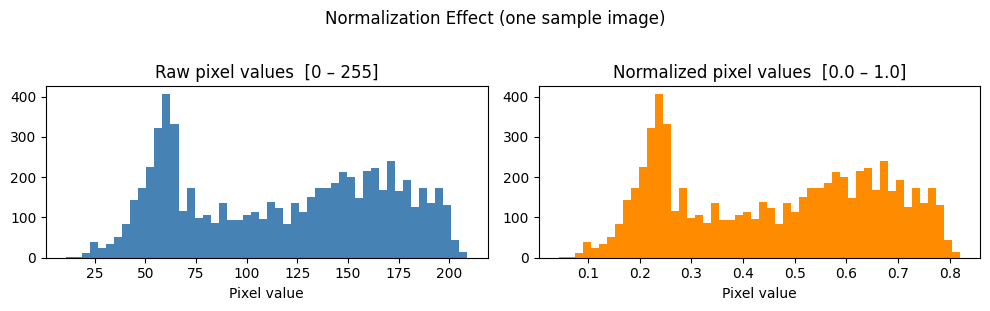

Raw    →  min=11  max=209  dtype=uint8
Normed →  min=0.043  max=0.820  dtype=float32


In [10]:
def normalize(img: Image.Image) -> np.ndarray:
    """Convert a PIL Image to a float32 numpy array in [0, 1]."""
    arr = np.array(img, dtype=np.float32)
    return arr / 255.0



sample_path = df[df['class'] == classes[0]].iloc[0]['path']
sample_pil  = Image.open(sample_path).convert('RGB')
sample_raw  = np.array(sample_pil)
sample_norm = normalize(sample_pil)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(sample_raw.ravel(),  bins=50, color='steelblue',  edgecolor='none')
axes[0].set_title('Raw pixel values  [0 – 255]')
axes[0].set_xlabel('Pixel value')

axes[1].hist(sample_norm.ravel(), bins=50, color='darkorange', edgecolor='none')
axes[1].set_title('Normalized pixel values  [0.0 – 1.0]')
axes[1].set_xlabel('Pixel value')

plt.suptitle('Normalization Effect (one sample image)', y=1.02)
plt.tight_layout()
plt.show()

print(f"Raw    →  min={sample_raw.min()}  max={sample_raw.max()}  dtype={sample_raw.dtype}")
print(f"Normed →  min={sample_norm.min():.3f}  max={sample_norm.max():.3f}  dtype={sample_norm.dtype}")

---
## Step 4 — Visualize Normalized Images

Compare how raw and normalized images look side by side. Visually they look identical — normalization only changes the number range, not the content.

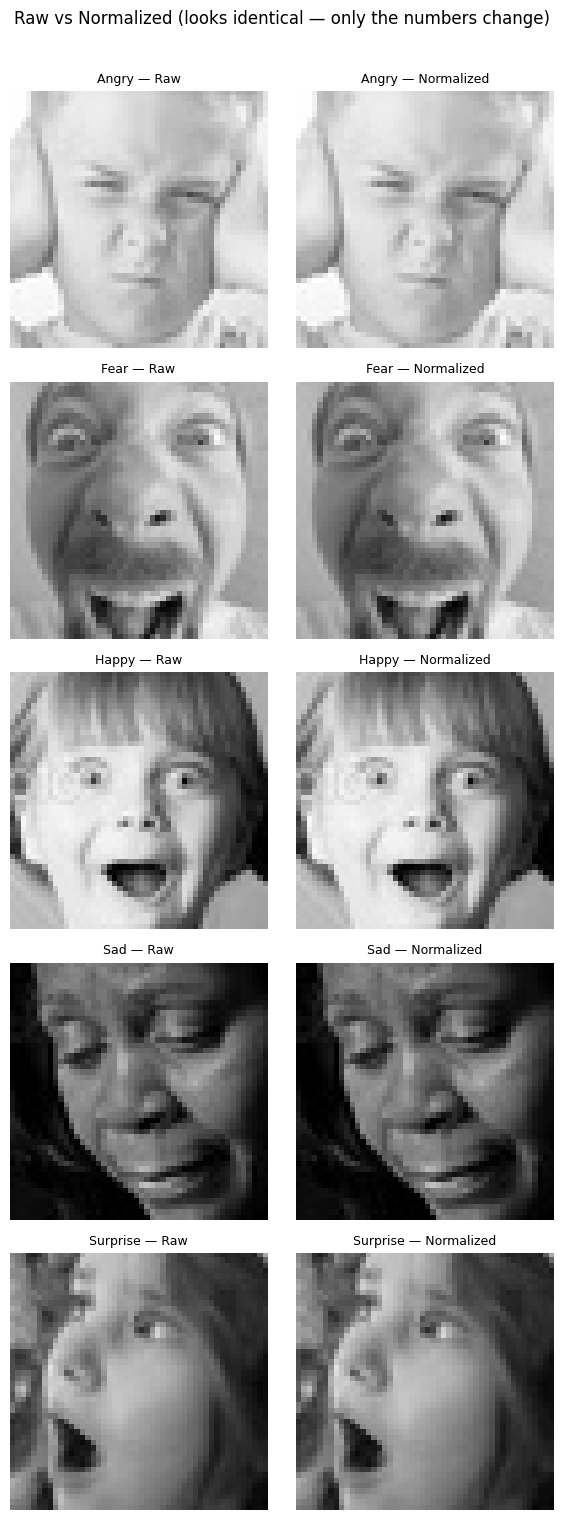

In [11]:
n_cols = 2   # raw | normalized
fig, axes = plt.subplots(len(classes), n_cols, figsize=(6, 3 * len(classes)))

for row, cls in enumerate(classes):
    sample_p = df[df['class'] == cls].sample(1).iloc[0]['path']
    raw_img  = Image.open(sample_p).convert('RGB')
    norm_arr = normalize(raw_img)

    axes[row, 0].imshow(raw_img)
    axes[row, 0].set_title(f'{cls} — Raw', fontsize=9)
    axes[row, 0].axis('off')

    axes[row, 1].imshow(norm_arr)   # matplotlib auto-clips [0,1] floats correctly
    axes[row, 1].set_title(f'{cls} — Normalized', fontsize=9)
    axes[row, 1].axis('off')

plt.suptitle('Raw vs Normalized (looks identical — only the numbers change)', y=1.01)
plt.tight_layout()
plt.show()

---
## Step 5 — Class Imbalance Analysis

Find out which classes are under-represented. The **target count** will be the size of the largest class — we augment smaller classes up to that number.

Class           Count    Needed
Angry            9722      8335
Fear             9193      8864
Happy           18057         0
Sad             12225      5832
Surprise         6721     11336
TARGET          18057

Imbalance ratio : 2.7x


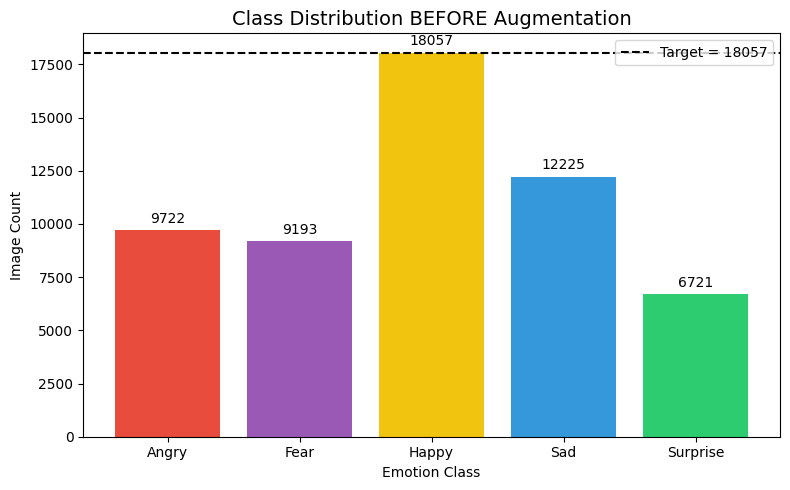

In [12]:
counts = df['class'].value_counts().sort_index()
TARGET_COUNT = int(counts.max())
imbalance_ratio = counts.max() / counts.min()

print(f"{'Class':<12} {'Count':>8}  {'Needed':>8}")
print("=" * 32)
for cls, cnt in counts.items():
    needed = max(0, TARGET_COUNT - cnt)
    print(f"{cls:<12} {cnt:>8}  {needed:>8}")
print("=" * 32)
print(f"{'TARGET':<12} {TARGET_COUNT:>8}")
print(f"\nImbalance ratio : {imbalance_ratio:.1f}x")

# Plot
colors_base = ['#e74c3c','#9b59b6','#f1c40f','#3498db','#2ecc71']
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(counts.index, counts.values, color=colors_base[:len(counts)])
ax.bar_label(bars, padding=3)
ax.axhline(TARGET_COUNT, color='black', linestyle='--', linewidth=1.5, label=f'Target = {TARGET_COUNT}')
ax.set_title('Class Distribution BEFORE Augmentation', fontsize=14)
ax.set_ylabel('Image Count')
ax.set_xlabel('Emotion Class')
ax.legend()
plt.tight_layout()
plt.show()

---
## Step 6 — Data Augmentation Pipeline

We define a set of random transforms that create realistic variations of an image:

| Transform | Why it helps |
|-----------|-------------|
| **Horizontal flip** | A face looking left vs right is the same emotion |
| **Random rotation ±15°** | Slight head tilts are normal |
| **Brightness / contrast jitter** | Accounts for different lighting conditions |
| **Random crop + resize** | Simulates different face positions in the frame |

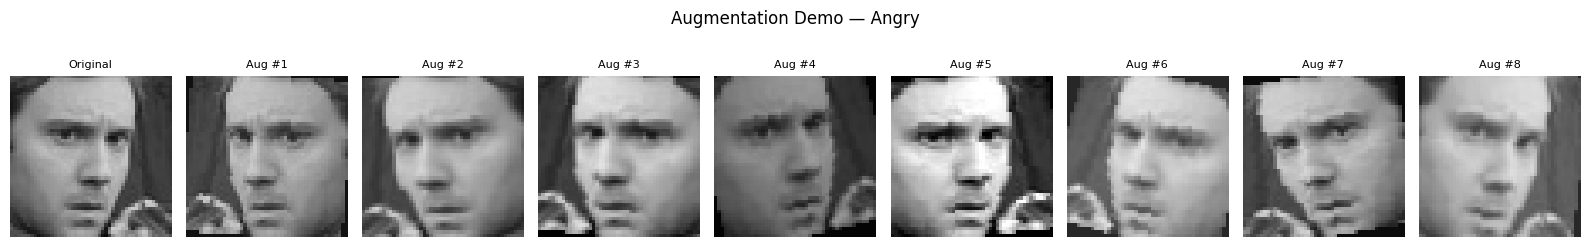

In [13]:
augment = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    T.RandomResizedCrop(size=(48, 48), scale=(0.85, 1.0)),
])

def augment_pil(img: Image.Image) -> Image.Image:
    """Apply augmentation pipeline and return a PIL Image."""
    return augment(img)

# Show 8 augmented variants of one image
demo_img = Image.open(df[df['class'] == classes[0]].iloc[0]['path']).convert('RGB')
n_aug = 8

fig, axes = plt.subplots(1, n_aug + 1, figsize=(16, 2.5))
axes[0].imshow(demo_img)
axes[0].set_title('Original', fontsize=8)
axes[0].axis('off')

for i in range(1, n_aug + 1):
    aug_img = augment_pil(demo_img)
    axes[i].imshow(aug_img)
    axes[i].set_title(f'Aug #{i}', fontsize=8)
    axes[i].axis('off')

plt.suptitle(f'Augmentation Demo — {classes[0]}', y=1.02)
plt.tight_layout()
plt.show()

---
## Step 7 — Apply Augmentation to Under-represented Classes

For each class with fewer images than the target:
1. Copy **all original images** to `Data_augmented/<class>/`
2. Randomly pick originals and apply augmentation until the class reaches `TARGET_COUNT`
3. Save each augmented image with the suffix `_aug_NNNN`

In [14]:
generated_summary = {}

for cls in sorted(classes):
    src_paths  = list((CLEAN_DIR / cls).glob('*.jpg'))
    dst_dir    = AUG_DIR / cls
    dst_dir.mkdir(parents=True, exist_ok=True)

    # Copy originals ---
    for p in tqdm(src_paths, desc=f'Copy [{cls}]', leave=False):
        dst = dst_dir / p.name
        if not dst.exists():
            Image.open(p).convert('RGB').save(dst, 'JPEG', quality=95)

    current_count = len(src_paths)
    needed        = max(0, TARGET_COUNT - current_count)

    # Generate augmented images ---
    aug_count = 0
    if needed > 0:
        pool = src_paths.copy()
        for i in tqdm(range(needed), desc=f'Augment [{cls}]'):
            src  = random.choice(pool)
            img  = Image.open(src).convert('RGB')
            aug  = augment_pil(img)
            name = f"{src.stem}_aug_{i:04d}.jpg"
            aug.save(dst_dir / name, 'JPEG', quality=95)
            aug_count += 1

    generated_summary[cls] = {
        'original':  current_count,
        'augmented': aug_count,
        'total':     current_count + aug_count,
    }
    print(f"  {cls:<12} original={current_count}  +augmented={aug_count}  → total={current_count + aug_count}")

print("\n Augmentation complete.")

Augment [Angry]: 100%|██████████| 8335/8335 [00:11<00:00, 702.71it/s]


  Angry        original=9722  +augmented=8335  → total=18057


Augment [Fear]: 100%|██████████| 8864/8864 [00:26<00:00, 334.98it/s]


  Fear         original=9193  +augmented=8864  → total=18057


  Happy        original=18057  +augmented=0  → total=18057


Augment [Sad]: 100%|██████████| 5832/5832 [00:19<00:00, 293.46it/s]


  Sad          original=12225  +augmented=5832  → total=18057


Augment [Surprise]: 100%|██████████| 11336/11336 [00:35<00:00, 322.94it/s]

  Surprise     original=6721  +augmented=11336  → total=18057

✅ Augmentation complete.


---
## Step 8 — Verify Balanced Dataset

Re-count images in `Data_augmented/` and confirm the classes are now balanced.

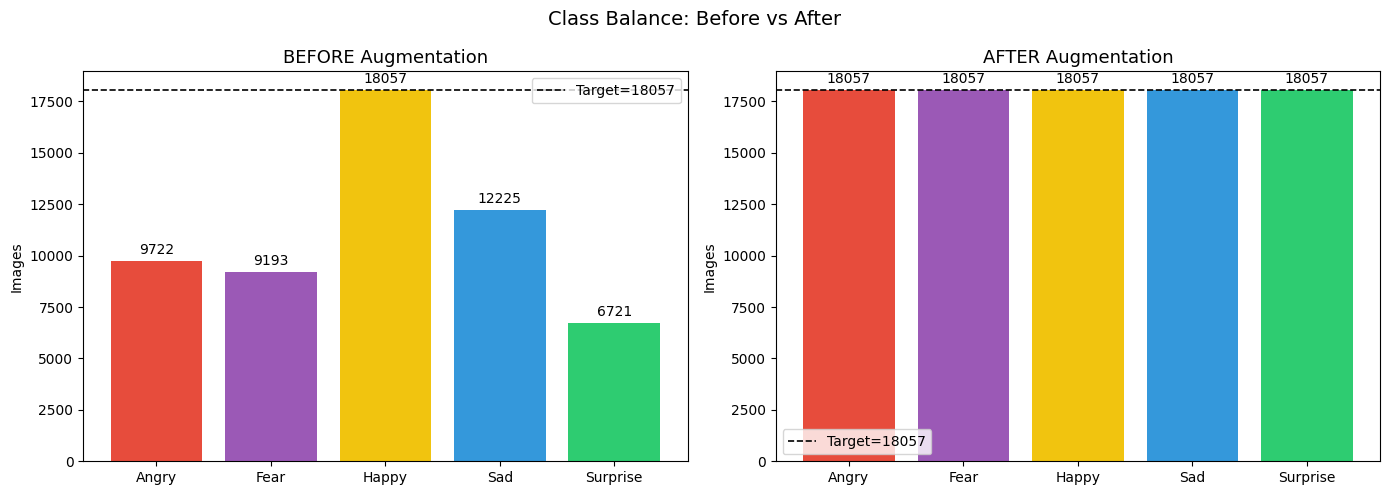


New imbalance ratio: 1.00x  (ideal = 1.0x)


In [15]:
aug_counts = {}
for cls in sorted(classes):
    aug_counts[cls] = len(list((AUG_DIR / cls).glob('*.jpg')))

new_max = max(aug_counts.values())
new_min = min(aug_counts.values())
new_ratio = new_max / new_min

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors_base = ['#e74c3c','#9b59b6','#f1c40f','#3498db','#2ecc71']

# Before
before = {row['class']: 0 for row in records}
for row in records:
    before[row['class']] += 1

b = axes[0].bar(before.keys(), before.values(), color=colors_base[:len(before)])
axes[0].bar_label(b, padding=3)
axes[0].set_title('BEFORE Augmentation', fontsize=13)
axes[0].set_ylabel('Images')
axes[0].axhline(TARGET_COUNT, color='black', linestyle='--', linewidth=1.2, label=f'Target={TARGET_COUNT}')
axes[0].legend()

# After
a = axes[1].bar(aug_counts.keys(), aug_counts.values(), color=colors_base[:len(aug_counts)])
axes[1].bar_label(a, padding=3)
axes[1].set_title('AFTER Augmentation', fontsize=13)
axes[1].set_ylabel('Images')
axes[1].axhline(TARGET_COUNT, color='black', linestyle='--', linewidth=1.2, label=f'Target={TARGET_COUNT}')
axes[1].legend()

plt.suptitle('Class Balance: Before vs After', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nNew imbalance ratio: {new_ratio:.2f}x  (ideal = 1.0x)")

---
## Step 9 — Final Summary

All images in `Data_augmented/` are:
-  48×48 pixels
-  RGB (3 channels)
-  Normalized to [0.0, 1.0] at training time (apply `/ 255` in your DataLoader)
-  Balanced across all classes

In [16]:
summary_df = pd.DataFrame(generated_summary).T.rename(columns={
    'original': 'Original', 'augmented': 'Generated', 'total': 'Total'
})
summary_df.index.name = 'Class'

print("=" * 48)
print(f"{'Class':<12} {'Original':>10} {'Generated':>10} {'Total':>10}")
print("=" * 48)
for cls, row in summary_df.iterrows():
    print(f"{cls:<12} {int(row['Original']):>10} {int(row['Generated']):>10} {int(row['Total']):>10}")
print("=" * 48)
print(f"{'TOTAL':<12} {int(summary_df['Original'].sum()):>10} "
      f"{int(summary_df['Generated'].sum()):>10} "
      f"{int(summary_df['Total'].sum()):>10}")

print(f"\n Balanced dataset saved to: {AUG_DIR}")
print(f" Next step: load Data_augmented/ into your CNN training pipeline!")

Class          Original  Generated      Total
Angry              9722       8335      18057
Fear               9193       8864      18057
Happy             18057          0      18057
Sad               12225       5832      18057
Surprise           6721      11336      18057
TOTAL             55918      34367      90285

 Balanced dataset saved to: C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented
 Next step: load Data_augmented/ into your CNN training pipeline!


---
## Step 10 — Train / Validation / Test Split

Split `Data_augmented/` into three subsets:

| Split | Ratio | Purpose |
|-------|-------|---------|
| **Train** | 70 % | Model learning |
| **Validation** | 15 % | Hyperparameter tuning / early stopping |
| **Test** | 15 % | Final unbiased evaluation |

The split is done **per class** (stratified) so each subset contains a proportional mix of all emotions.

  Angry         total=18057  train=12639  val=2708  test=2710
  Fear          total=18057  train=12639  val=2708  test=2710
  Happy         total=18057  train=12639  val=2708  test=2710
  Sad           total=18057  train=12639  val=2708  test=2710
  Surprise      total=18057  train=12639  val=2708  test=2710

Class           Train      Val     Test    Total
Angry           12639     2708     2710    18057
Fear            12639     2708     2710    18057
Happy           12639     2708     2710    18057
Sad             12639     2708     2710    18057
Surprise        12639     2708     2710    18057
TOTAL           63195    13540    13550    90285


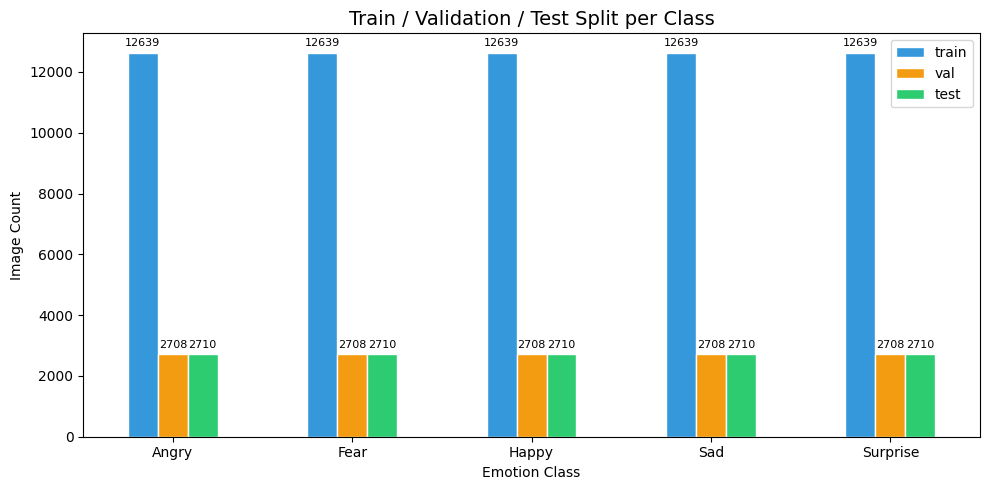


 Split summary complete (images remain in Data_augmented/ — split indices stored in memory).


In [17]:
import math

TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
# TEST_RATIO  = 1 - TRAIN_RATIO - VAL_RATIO  = 0.15

split_summary = {}

for cls in sorted(classes):
    img_paths = sorted((AUG_DIR / cls).glob('*.jpg'))
    random.shuffle(img_paths)           # reproducible if you set random.seed() above

    n       = len(img_paths)
    n_train = math.floor(n * TRAIN_RATIO)
    n_val   = math.floor(n * VAL_RATIO)
    n_test  = n - n_train - n_val       # remainder goes to test

    splits = {
        'train': img_paths[:n_train],
        'val':   img_paths[n_train : n_train + n_val],
        'test':  img_paths[n_train + n_val :],
    }

    split_summary[cls] = {s: len(v) for s, v in splits.items()}
    print(f"  {cls:<12}  total={n:>5}  "
          f"train={n_train:>5}  val={n_val:>4}  test={n_test:>4}")

# Pretty table 
print("\n" + "=" * 52)
print(f"{'Class':<12} {'Train':>8} {'Val':>8} {'Test':>8} {'Total':>8}")
print("=" * 52)
totals = {'train': 0, 'val': 0, 'test': 0}
for cls, s in split_summary.items():
    print(f"{cls:<12} {s['train']:>8} {s['val']:>8} {s['test']:>8} {sum(s.values()):>8}")
    for k in totals:
        totals[k] += s[k]
print("=" * 52)
print(f"{'TOTAL':<12} {totals['train']:>8} {totals['val']:>8} {totals['test']:>8} "
      f"{sum(totals.values()):>8}")

# Bar chart
split_df = pd.DataFrame(split_summary).T[['train', 'val', 'test']]
ax = split_df.plot(kind='bar', figsize=(10, 5), color=['#3498db', '#f39c12', '#2ecc71'],
                   edgecolor='white')
ax.set_title('Train / Validation / Test Split per Class', fontsize=14)
ax.set_ylabel('Image Count')
ax.set_xlabel('Emotion Class')
ax.set_xticklabels(split_df.index, rotation=0)
for container in ax.containers:
    ax.bar_label(container, padding=3, fontsize=8)
plt.tight_layout()
plt.show()

print("\n Split summary complete (images remain in Data_augmented/ — split indices stored in memory).")


---
## Step 11 — Label Encoding

Map each class name to an integer so the model can process targets numerically:

| Class | Label |
|-------|-------|
| Angry | 0 |
| Fear | 1 |
| Happy | 2 |
| Sad | 3 |
| Surprise | 4 |

We also build a reverse mapping (`label → class name`) for later use during inference / reporting.

Label encoding map:
  Angry        → 0
  Fear         → 1
  Happy        → 2
  Sad          → 3
  Surprise     → 4

Decoding map:
  0  → Angry
  1  → Fear
  2  → Happy
  3  → Sad
  4  → Surprise

Split sizes  →  train=63195  val=13540  test=13550


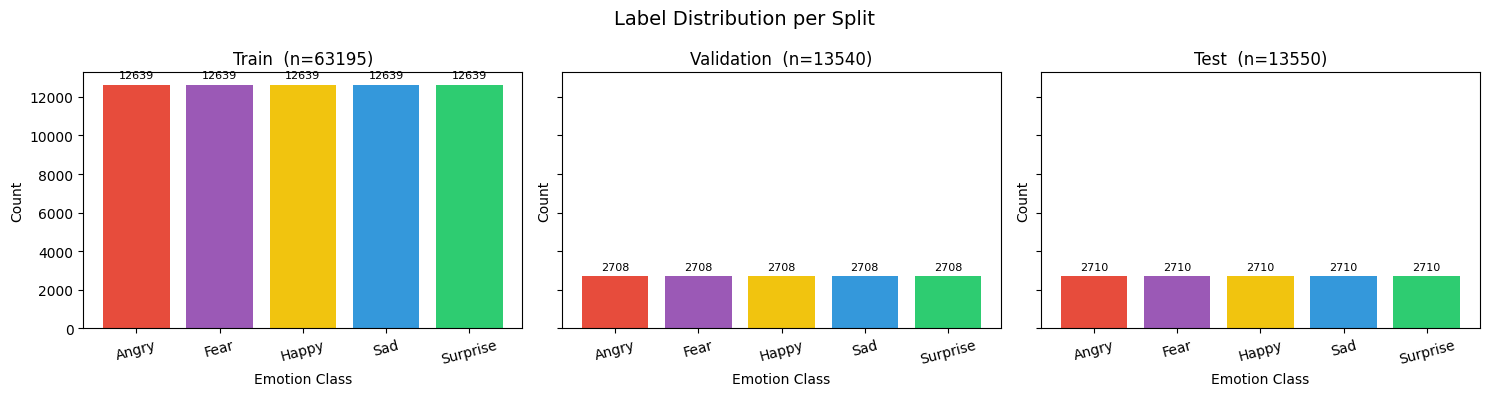


Sample rows from train_df:
                                                                                     path class  label
            C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\Fear\34723.jpg  Fear      1
        C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\Fear\478615573.jpg  Fear      1
    C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\Fear\7285_aug_0419.jpg  Fear      1
             C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\Sad\16246.jpg   Sad      3
        C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\Angry\89267452.jpg Angry      0
C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\Sad\119832843_aug_3570.jpg   Sad      3
     C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\Sad\1148_aug_4356.jpg   Sad      3
         C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\Sad\828261888.jpg   Sad      3

 Label encoding complete. Use `label_encode`

In [ ]:
# Label maps 
CLASS_NAMES  = sorted(classes)                         # ['Angry','Fear','Happy','Sad','Surprise']
label_encode = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
label_decode = {idx: cls for cls, idx in label_encode.items()}

print("Label encoding map:")
for cls, idx in label_encode.items():
    print(f"  {cls:<12} → {idx}")

print("\nDecoding map:")
for idx, cls in label_decode.items():
    print(f"  {idx}  → {cls}")

#  Build encoded DataFrames for each split 
def build_split_df(split_key: str) -> pd.DataFrame:
    rows = []
    for cls in CLASS_NAMES:
        img_paths = sorted((AUG_DIR / cls).glob('*.jpg'))
        random.shuffle(img_paths)

        n       = len(img_paths)
        n_train = math.floor(n * TRAIN_RATIO)
        n_val   = math.floor(n * VAL_RATIO)

        mapping = {
            'train': img_paths[:n_train],
            'val':   img_paths[n_train : n_train + n_val],
            'test':  img_paths[n_train + n_val :],
        }
        for p in mapping[split_key]:
            rows.append({'path': str(p), 'class': cls, 'label': label_encode[cls]})
    return pd.DataFrame(rows).sample(frac=1).reset_index(drop=True)   # shuffle rows

# Re-build with a fixed seed for reproducibility
random.seed(42)
train_df = build_split_df('train')
random.seed(42)
val_df   = build_split_df('val')
random.seed(42)
test_df  = build_split_df('test')

print(f"\nSplit sizes  →  train={len(train_df)}  val={len(val_df)}  test={len(test_df)}")

# Verify label distribution in each split 
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
colors_base = ['#e74c3c','#9b59b6','#f1c40f','#3498db','#2ecc71']

for ax, (name, sdf) in zip(axes, [('Train', train_df), ('Validation', val_df), ('Test', test_df)]):
    counts_s = sdf['class'].value_counts().sort_index()
    bars = ax.bar(counts_s.index, counts_s.values, color=colors_base[:len(counts_s)])
    ax.bar_label(bars, padding=3, fontsize=8)
    ax.set_title(f'{name}  (n={len(sdf)})', fontsize=12)
    ax.set_xlabel('Emotion Class')
    ax.set_ylabel('Count')
    ax.set_xticklabels(counts_s.index, rotation=15)

plt.suptitle('Label Distribution per Split', fontsize=14)
plt.tight_layout()
plt.show()

print("\nSample rows from train_df:")
print(train_df.head(8).to_string(index=False))
print("\n Label encoding complete. Use `label_encode`, `label_decode`, `train_df`, `val_df`, `test_df` downstream.")


---
## Step 12 — Save Split Index CSVs (Portable / Colab-Ready)

Instead of storing absolute paths (which break on any other machine), we save **relative paths** — relative to `Data_augmented/`. 

| File | Columns | Example `rel_path` value |
|------|---------|--------------------------|
| `train.csv` | `rel_path, class, label` | `Angry/img001.jpg` |
| `val.csv`   | `rel_path, class, label` | `Fear/img042_aug_0003.jpg` |
| `test.csv`  | `rel_path, class, label` | `Happy/img010.jpg` |

**To use on any machine (including Colab):**
```python
BASE_DIR = Path('/content/drive/MyDrive/Data_augmented')  # set once per environment
df = pd.read_csv('splits/train.csv')
df['full_path'] = df['rel_path'].apply(lambda p: BASE_DIR / p)
```

In [ ]:
SPLITS_DIR = AUG_DIR / 'splits'
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

csv_paths = {
    'train': SPLITS_DIR / 'train.csv',
    'val':   SPLITS_DIR / 'val.csv',
    'test':  SPLITS_DIR / 'test.csv',
}

for split_name, sdf in [('train', train_df), ('val', val_df), ('test', test_df)]:
    # Store RELATIVE path (class/filename.jpg) — works on any OS / Colab
    portable = sdf.copy()
    portable['rel_path'] = portable['path'].apply(
        lambda p: '/'.join(Path(p).parts[-2:])   # e.g. "Angry/img001.jpg"
    )
    portable = portable[['rel_path', 'class', 'label']]

    out = csv_paths[split_name]
    portable.to_csv(out, index=False)
    print(f"  {split_name:<6}  {len(portable):>5} rows  →  {out}")

# ── Sanity check ──────────────────────────────────────────────────────────────
print("\nSample rows from train.csv (relative paths):")
print(pd.read_csv(csv_paths['train']).head(5).to_string(index=False))

print(f"""
✅ Portable CSVs saved to: {SPLITS_DIR}

── How to load on ANY machine ──────────────────────────────────────────
  import pandas as pd
  from pathlib import Path

  # Change only this line per environment:
  BASE_DIR = Path('/content/drive/MyDrive/Data_augmented')  # Colab
  # BASE_DIR = Path('C:/Nemeno/.../Data_augmented')         # Windows

  df = pd.read_csv('splits/train.csv')
  df['full_path'] = df['rel_path'].apply(lambda p: BASE_DIR / p)
────────────────────────────────────────────────────────────────────────
""")


  train   63195 rows  →  C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\splits\train.csv
  val     13540 rows  →  C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\splits\val.csv
  test    13550 rows  →  C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\splits\test.csv

Sample rows from train.csv:
                                                                                 path class  label
        C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\Fear\34723.jpg  Fear      1
    C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\Fear\478615573.jpg  Fear      1
C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\Fear\7285_aug_0419.jpg  Fear      1
         C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\Sad\16246.jpg   Sad      3
    C:\Nemeno\3rd year\2nd sem\IS2\activities\act_3\Data_augmented\Angry\89267452.jpg Angry      0

✅ Split CSVs saved to: C:\Nemeno\3rd year\2nd sem\IS2\activities